# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd
from collections import defaultdict

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
    - [Finger Load Comparison](#finger-load)
    - [Which Rows do Keys Gravitate to](#rows-gravitation)
    - [Bigrams vs Position Penalties](#bigram-position-chart)
- [Test your layout here](#your-layout)
    - [Export any layout to Linux XKB](#export-to-xkb)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt', types={'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'})

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м   159  ¶  м  -  c  0.000174
1        мо  3241  м  о  c  v  0.003554
2        ож  1890  о  ж  v  c  0.002073
3        же  2825  ж  е  c  v  0.003098
4        ет  5188  е  т  v  c  0.005689
...     ...   ... .. .. .. ..       ...
2682     oн     1  o  н  -  c  0.000001
2683     нa     1  н  a  c  -  0.000001
2684     еp     1  е  p  v  -  0.000001
2685     yг     1  y  г  -  c  0.000001
2686     гy     1  г  y  c  -  0.000001

[2687 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   71951
е   58480
а   54526
и   44490
т   42842
н   34441
р   30361
л   28373
с   26001
в   19409
к   17751
м   17189
д   16076
у   15812
ы   13770
ь   13741
я   12830
з    8539
й    8514
г    8425
б    7297
ч    7212
ж    5906
х    5796
п    5654
ю    4653
ш    4591
ц    2550
щ    2470
ё    1222
ф     938
ъ     273
э     268

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

freq_out     freq_in      outer   frequency     outerness
ъ   2.949778    0.000000  -2.949778    2.949778 -10000.000000
ы  18.970692    0.032897 -18.937795   19.003589  -9965.377957
ь   9.880112    0.021931  -9.858180    9.902043  -9955.703212
а  53.874572    7.050957 -46.823615   60.925529  -7685.385169
о  44.959443    9.715626 -35.243817   54.675069  -6446.048937
у  16.042845    4.759122 -11.283724   20.801967  -5424.354244
и  71.331995   26.229997 -45.101998   97.561992  -4622.906598
е  21.383150  103.088714  81.705564  124.471864   6564.179367
я   5.647345   54.346098  48.698753   59.993443   8117.346006
э   0.032897    1.447475   1.414578    1.480372   9555.555556
ю   0.394766   35.912726  35.517960   36.307492   9782.543038
ё   0.000000    2.862052   2.862052    2.862052  10000.000000

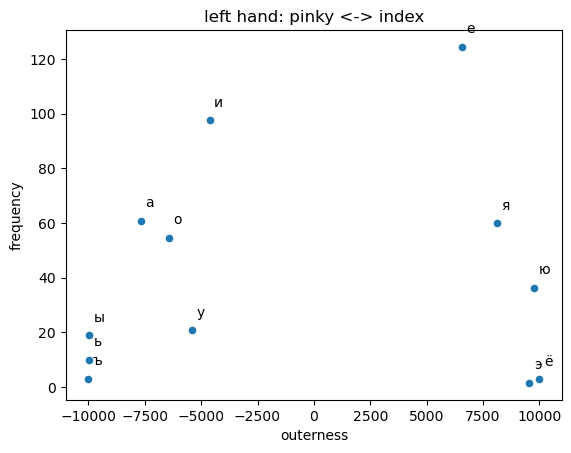

In [5]:
CORP.display_outerness("(t1 == 'v') & (t2 == 'v')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
щ     0.701806    5.044230   -4.342424    5.746036 -7557.251908
ц     1.173332    8.410706   -7.237374    9.584037 -7551.487414
л    21.503773   82.396404  -60.892631  103.900177 -5860.686016
р    51.900743  165.768757 -113.868014  217.669500 -5231.234257
н    62.559420  156.919423  -94.360002  219.478843 -4299.275543
т   103.461548  183.763500  -80.301952  287.225048 -2795.785133
к    43.413277   74.281773  -30.868496  117.695050 -2622.752259
м    21.624396   23.642088   -2.017692   45.266483  -445.736434
ф     2.620807    2.686601   -0.065794    5.307407  -123.966942
в    67.439165   61.660232    5.778933  129.099397   447.634418
ш    13.136930   10.176186    2.960744   23.313116  1269.990593
д    53.710086   40.200322   13.509764   93.910408  1438.580103
х     8.224288    5.680242    2.544047   13.904530  1829.652997
г    27.589746   11.963598   15.626148   39.553344  3950.651511
ж    21.942401    7.928214   14.014187   29.870615  4691.629956
с   241.541868   86.333097  155.208771  327.874964  4733.779264
ч    39.970042   11.042478   28.927564   51.012520  5670.679278
п    81.223072   21.536670   59.686402  102.759742  5808.344894
б    30.276347    5.680242   24.596105   35.956589  6840.500152
з    55.508464    4.210836   51.297628   59.719300  8589.790672
й    19.815052    0.010966   19.804086   19.826018  9988.938053

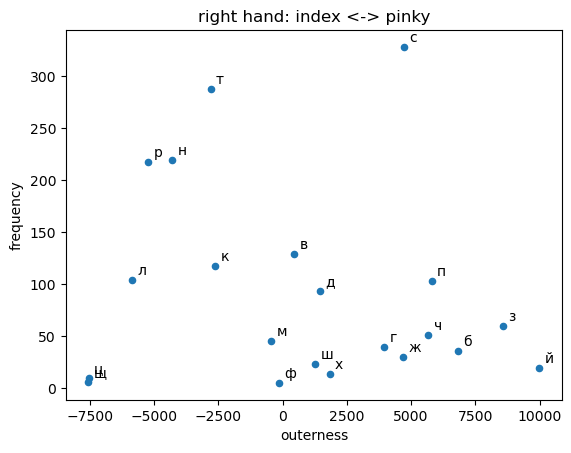

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [8]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
987643 422389
864223 43124689
 21002 2001246
 42114 411224
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [9]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
9863226 622489
8642134 431246
 421002 200124
 642114 4112
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [10]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32букваП': r'''    
ъ12345 67890-=
→фуыхэ жшвкчзщ/
 поией ,ртнсд¶
 ьаёяю цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест38': r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест39': r'''
ъ12345 67890-=
→фёыхэ шмвкчйц
 аиое, зртнсг¶
 щьуяю жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    
}

    

In [11]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 3.2331
key """ repeated: 2
key "?" repeated: 2
layout usphonetic: 3.6617
layout rusdvorak: 2.2788
key ":" repeated: 2
layout диктор: 1.8585
layout зубачёв: 1.8349
key "." repeated: 2
layout скоропис: 1.8104
key """ repeated: 3
key ":" repeated: 2
key ";" repeated: 2
layout ант: 2.1368
layout ugnvs: 2.6043
layout леонов: 1.647
layout леонов2: 1.7273
layout леонов3: 1.7866
layout тест1: 2.9587
layout тест2: 2.7825
layout тест3: 2.4815
layout тест4: 2.3548
layout тест5: 2.2107
layout тест6: 2.314
layout тест7: 2.3309
layout тест8: 2.2846
layout тест9: 2.293
layout тест10: 2.3272
layout тест11: 2.3278
layout тест12: 2.1268
layout тест13: 2.1426
layout тест14: 2.0798
layout тест15: 2.0066
layout тест16: 1.9994
layout тест17: 1.9683
layout тест18: 2.0327
layout тест19: 2.1026
layout тест20: 2.101
layout тест21: 2.0146
layout тест22: 2.0146
layout тест23: 1.982
layout тест24: 1.9337
layout тест25: 1.9757
layout ино1: 1.8441
layout тест26: 1.903
layout тест27: 1.9323
layout ино2

# Final Standings <a name="standings">

In [12]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест39', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   1.572 | Alien #2, many counterparts on AltGr   |
| леонов     |   1.647 | Leonov                                 |
| тест39     |   1.729 | Best and currently in use on my laptop |
| скоропис   |   1.81  | Skoropis                               |
| зубачёв    |   1.835 | Zubachov                               |
| ино1       |   1.844 | Alien #1, rare letters on AltGr        |
| диктор     |   1.859 | Dictor                                 |
| ант        |   2.137 | ANT                                    |
| rusdvorak  |   2.279 | Dvorak translit                        |
| тест9      |   2.293 | First hand-tested                      |
| тест10     |   2.327 | First optimized after hand testing     |
| ugnvs      |   2.604 | UGNVS                                  |
| тест2      |   2.782 | My first Dvorak analog  

## Finger Load Comparison <a name='finger-load'/>

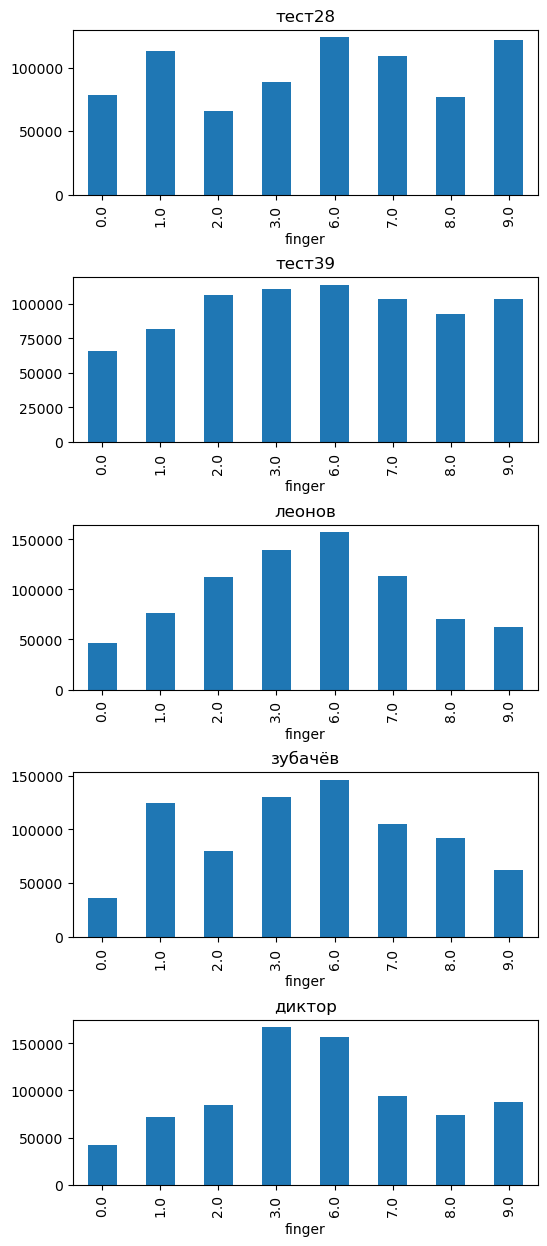

In [13]:
keys = ('тест28', 'тест39', 'леонов', 'зубачёв', 'диктор')
from matplotlib import pyplot as plt
fig, axs = plt.subplots(len(keys), 1, figsize=(6, 15))
plt.subplots_adjust(hspace=.5)
dfs = []
for k, ax in zip(keys, axs):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d.plot.bar(ax=ax, title=k, legend=False)

## Which Rows do Keys Gravitate to <a name='rows-gravitation'>
    
In this chart, we show how many bigrams do letters have with rows 1-3 (main key rows). If a key in bottom row has most bigrams in bottom or middle row, it's fine in that position. This chart actually shows that almost all letters are in their best places.
    
note: This calculation excludes combos with keys on another hand, and with the key itself (НН is quite popular that it distorts the stats significantly).

Letter В (v) may gain a little bit in the bottom row, but letters in that row will loose more.

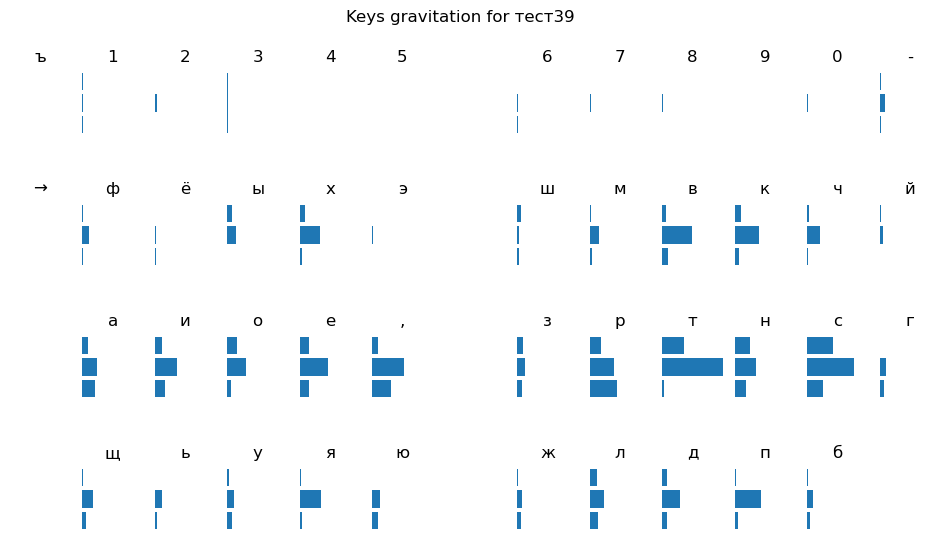

In [14]:
results['тест39'].display('rows')

# Bigrams vs Position Penalties <a name='bigram-position-chart'/>

### Theoretical minimal score

This calculation shows how low could the score be if we put keys ordered by frequencies, and there were no bigrams penalties:

In [15]:
pos_penalties = [r['penalty'] for r in STANDARD_KBD.keymap.values()]
pos_penalties.sort()
freqs = CORP.bigrams.groupby('l2').agg({'freq': 'sum'}).sort_values('freq', ascending=False).values
min_score = sum(a * b for a, b in zip(freqs, pos_penalties))[0]
min_score

1.0140426983122657

(1.0140426983122657, 3.1069500000000003)

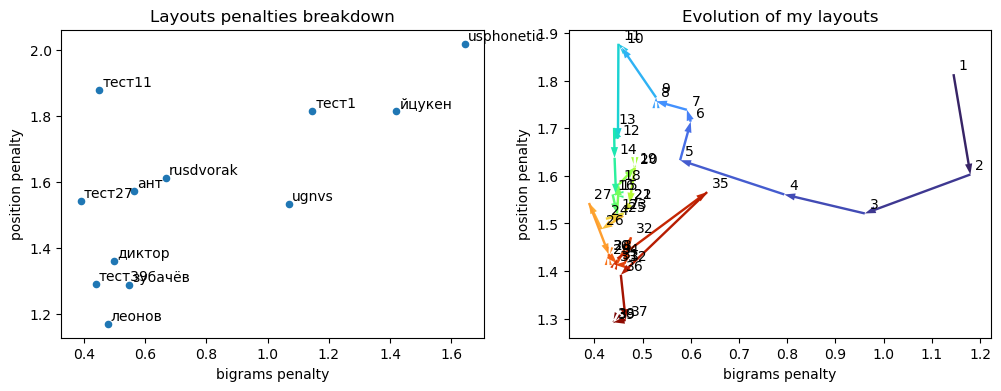

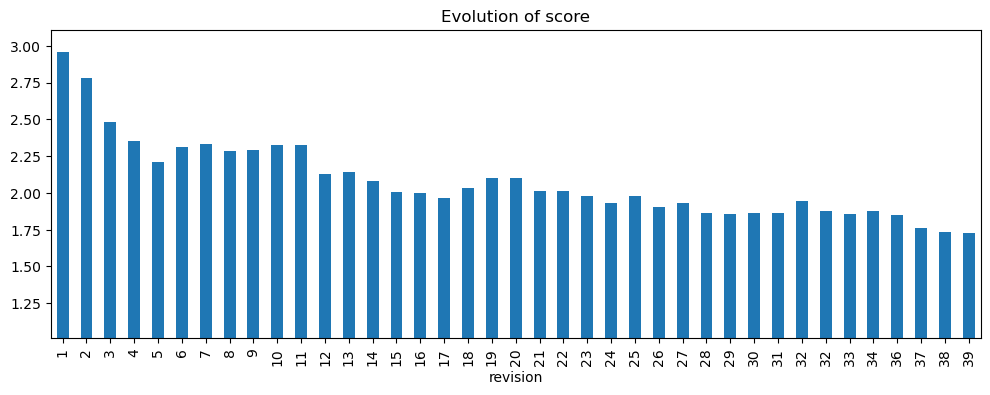

In [16]:
dd = []
for k, v in results.items():
#    if k.startswith('тест') and not k.startswith('тест37'): continue
    if k.startswith('леонов') and not k == 'леонов': continue
    if k.startswith('ино'): continue
    if k.startswith('скоропис'): continue
    b = results[k].bigrams
    dd.append({
        'name': k, 
        'pos': round((b.price_l2 * b.num).sum() / b.num.sum(), 3),
        'bigram': round((b.price_di * b.num).sum() / b.num.sum(), 3)
    })
    
df2 = pd.DataFrame(dd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# selecting layouts to display their scores
df3 = df2[~df2.name.str.startswith('тест') | df2.name.isin(['тест39', 'тест27', 'тест1', 'тест11'])]
df3.plot.scatter(x='bigram', y='pos', ax=ax1)
for i, r in df3.iterrows():
    ax1.annotate(r['name'], (r.bigram + .01, r.pos + .01))

for a in (ax1, ax2):
    a.set_xlabel('bigrams penalty')
    a.set_ylabel('position penalty')

ax1.set_title('Layouts penalties breakdown')
ax2.set_title('Evolution of my layouts')

import re
df4 = df2[df2.name.apply(lambda k: re.match(r'тест(\d+)', k) is not None)].copy()
df4['revision'] = df4.name.apply(lambda k: int(re.match(r'тест(\d+)', k).groups()[0]))
df4.sort_values('revision', inplace=True)
df4['pos1'] = df4.pos.diff(-1)
df4['bigram1'] = df4.bigram.diff(-1)
maxnum = df4.revision.max() - 1
for _, r in df4.iterrows():
    ax2.arrow(
        r['bigram'], r['pos'], -r['bigram1'], -r['pos1'],
        width=.005,
        length_includes_head=True, ec='#00000000',
        color=plt.cm.turbo(r.revision / maxnum)
    )
    ax2.annotate(r.revision, (r['bigram'] + .01, r['pos'] + .01))

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df5 = df4[df4.revision != 35].set_index('revision')
scores = (df5['pos'] + df5['bigram'])
scores.plot.bar(ax=ax, title='Evolution of score')
ax.set_ylim(min_score, scores.max() * 1.05)

How to read the charts above:

* Layout penalties
    * dots on the left have more convenient roll-ins (or alternating hands
    * dots in the bottom have fingers work more in home position
* Evolution of my layouts: dimensions are the same
    * notice: the criteria for convenience were different.
    * some layouts move up-left -- these were optimizations of bigrams that turned out worse in real testing, because some awkward position wasn't penalized.
* Evolution of score (bottom)
    * Local peaks were revisions where improvement of score made the layout noteably worse in typing test. Score rules were then updated, and after that, the revision scored worse than previous ones.

Notes:

1. A complete improvement (within the scoring system) is when a layout is both lower and to the left of the other one.
2. If two layouts are on a line from left-up to right-down, then they have tradeoffs, none is better.
3. The best layouts are `леонов`, `тест27`, and `тест39`. All other layouts are worse than theese (they have both scores worse).
4. Scores started to be changed starting from layout 10.
5. Layout 35 was an attempt to move vowels on the right side.
6. Leonov's layout has comma and period on chords, hence it spares a good deal of penalty (costs of chording aren't calculated).



# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

<AxesSubplot: title={'center': 'real fingers with monogram penalties'}>

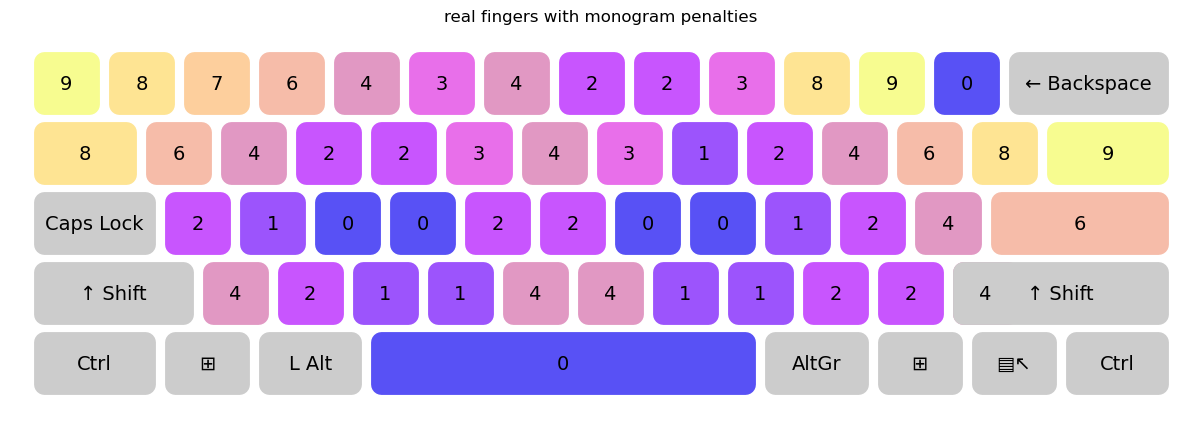

In [17]:
real_kbd.display()

тест40 : 1.717 


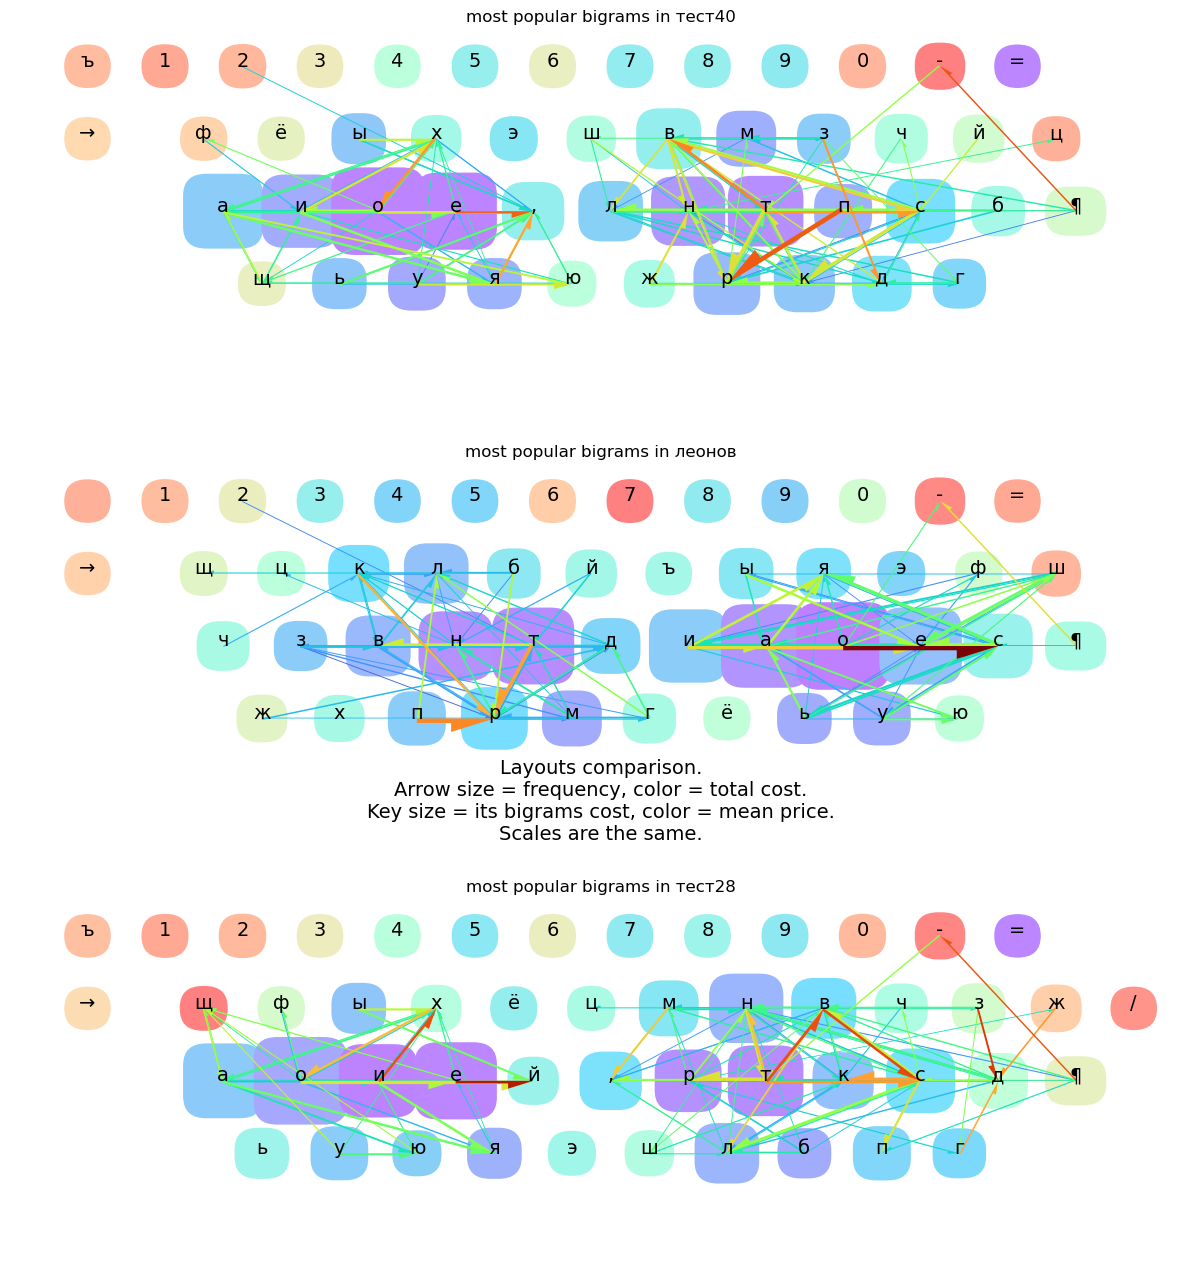

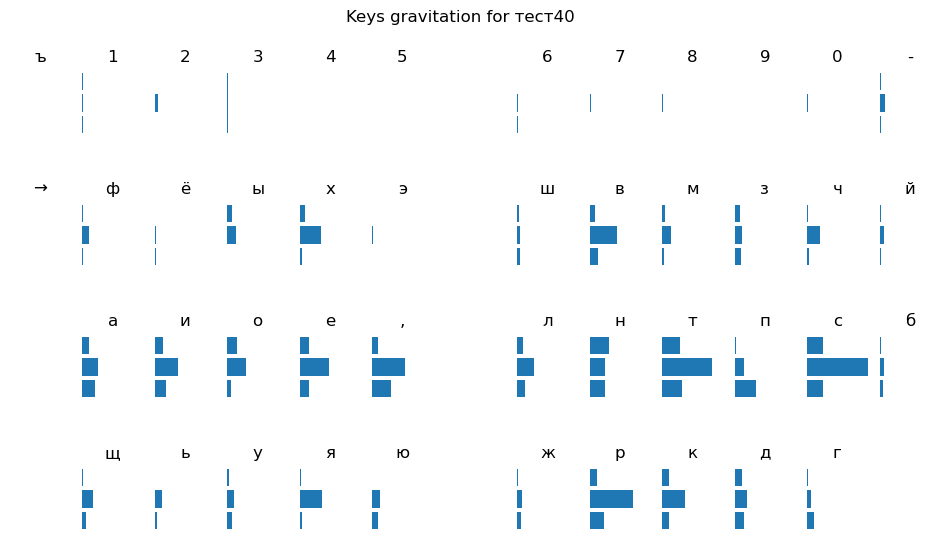

In [18]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

lyt = Layout('тест40', (r'''
ъ12345 67890-=
→фёыхэ швмзчйц
 аиое, лнтпсб¶
 щьуяю жркдг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

r.combomap(results['леонов'], results['тест28'])
r.display('rows')

check which side and row letters gravitate to in a layout result (this depends on corpus stats, hence it should be done in a Result instance)


# Export Your Or Other Layout to Linux xkb <a name='export-to-xkb'/>

Run the next cell, and it will output layout variant block. You should copy and paste it into some `/usr/share/X11/xkb/symbols/*` file. To show it in layouts, add it to `/usr/share/X11/xkb/rules/evdev.xml`:

```
    <layout>
      <configItem>
        <name>[name of the file in symbols]</name>
        <shortDescription>ru</shortDescription>
        <description>Russian</description>
        <countryList>
          <iso3166Id>RU</iso3166Id>
          <iso3166Id>KZ</iso3166Id>
        </countryList>
        <languageList>
          <iso639Id>rus</iso639Id>
        </languageList>
      </configItem>
      <variantList>
        <variant>
          <configItem>
            <name>[the same name as in xkb_symbols "<name>"]</name>
            <description>[title]</description>
          </configItem>
        </variant>
      </variantList>
    </layout>
```

In [19]:
results['тест39'].layout.export()


	default partial alphanumeric_keys
	xkb_symbols "тест39" {
		include "ru(common)"
		name[Group1]= "Culebron (тест39)";
			key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN, backslash ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };
	key <AD01> { [ Cyrillic_ef, Cyrillic_EF ] };
	key <AD02> { [ Cyrillic_io, Cyrillic_IO ] };
	key <AD03> { [ Cyrillic_yeru, Cyrillic_YERU ] };
	key <AD04> { [ Cyrillic_ha, Cyrillic_HA ] };
	key <AD05> { [ Cyrillic_e, Cyrillic_E ] };
	key <AD06> { [ Cyrillic_sha, Cyrillic_SHA ] };
	key <AD07> { [ Cyrillic_em, Cyrillic_EM ] };
	key <AD08> { [ Cyrillic_ve, Cyrillic_VE ] };
	key <AD09> { [ Cyrillic_ka, Cyrill

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

bigram   num                     category_old  price_old  cost_old  \
181     ой  3205      in, over 1 finger, same row          2      6410   
23      ⌴и  9284                        space bar          0         0   
272     е,  1459                     altern hands          2      2918   
15      ни  7156                     altern hands          0         0   
132     я,  1162                     altern hands          2      2324   
153     ог  3341                     altern hands          2      6682   
79      ⌴г  3298                        space bar          2      6596   
7       ли  5507                     altern hands          0         0   
365     е.   905                     altern hands          2      1810   
225     ⌴б  4888                        space bar          1      4888   
350     я.   806                     altern hands          2      1612   
222     йс   467                     altern hands          2       934   
28      ри  4244                     altern hands          0         0   
332     ег  1977                     altern hands          2      3954   
33      ти  3904                     altern hands          0         0   
184     ое  1887      in, over 1 finger, same row          0         0   
412     дв   536       in, over 1 finger, adj row          2      1072   
237     ый  1240       in, over 1 finger, adj row          3      3720   
498     зм   567      in, over 1 finger, same row          3      1701   
187     об  3213                     altern hands          1      3213   
162     аю  1053       in, over 1 finger, adj row          2      2106   
378     ую  1019  in, adj finger, same or adj row          3      3057   
281     ай   756      in, over 1 finger, same row          2      1512   
464     зв   753      in, over 1 finger, same row          1       753   
164     о,  1483                     altern hands          2      2966   
411     дн  1467  in, adj finger, same or adj row          3      4401   
110     ки  2886                     altern hands          0         0   
229     лю   960                     altern hands          1       960   
257     ои   917  in, adj finger, same or adj row          2      1834   
247     иц   647                     altern hands          4      2588   

                        category_new  price_new  cost_new  delta  
181                     altern hands          6     19230  12820  
23                         space bar          1      9284   9284  
272              same finger adj row          8     11672   8754  
15                      altern hands          1      7156   7156  
132              same finger adj row          8      9296   6972  
153                     altern hands          4     13364   6682  
79                         space bar          4     13192   6596  
7                       altern hands          1      5507   5507  
365              same finger adj row          8      7240   5430  
225                        space bar          2      9776   4888  
350              same finger adj row          8      6448   4836  
222                    pinky adj row         12      5604   4670  
28                      altern hands          1      4244   4244  
332                     altern hands          4      7908   3954  
33                      altern hands          1      3904   3904  
184  in, adj finger, same or adj row          2      3774   3774  
412             same finger over row          9      4824   3752  
237                     altern hands          6      7440   3720  
498              same finger adj row          9      5103   3402  
187                     altern hands          2      6426   3213  
162       in, over 1 finger, adj row          5      5265   3159  
378  in, adj finger, same or adj row          6      6114   3057  
281                     altern hands          6      4536   3024  
464             out, over one finger          5      3765   3012  
164  in, adj finger, same or adj r

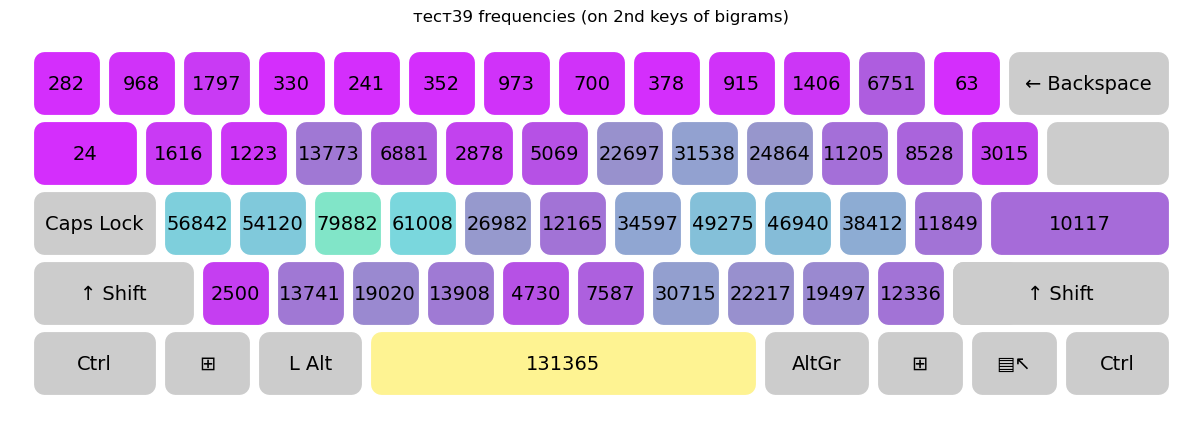

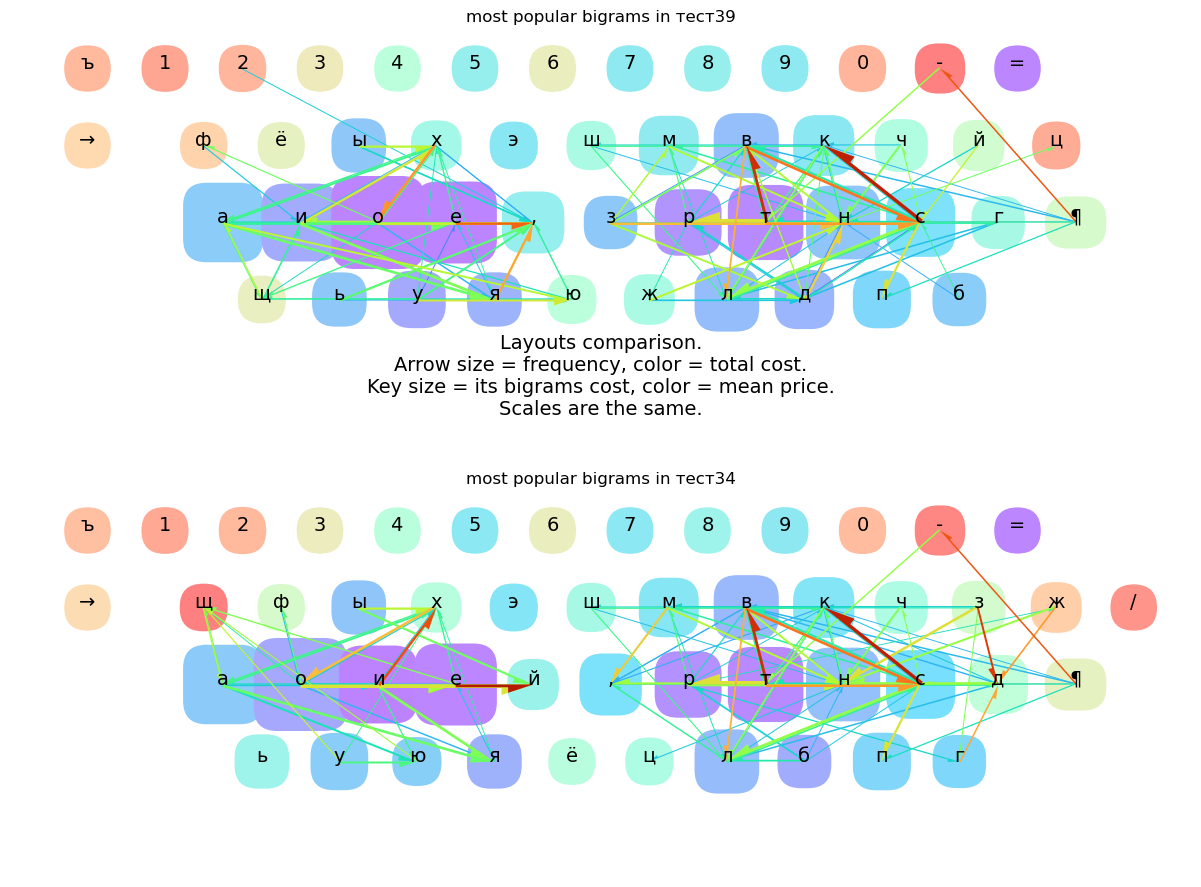

In [20]:
results['тест39'].display('num')
results['тест39'].combomap(results['тест34'])
results['тест34'].compare(results['тест39']).sort_values('delta', ascending=False).head(30)

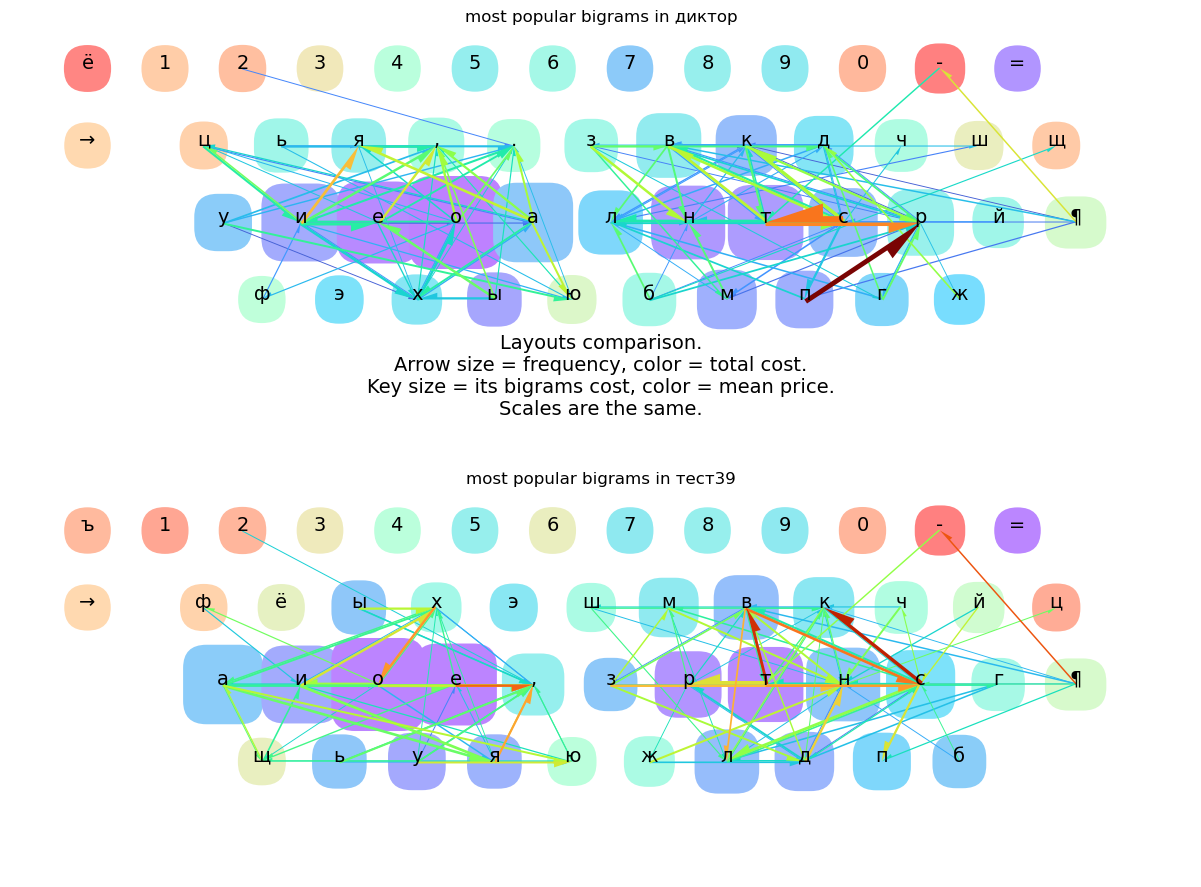

In [21]:
results['диктор'].combomap(results['тест39'])

## Losses

In [22]:
compare(results, 'тест34', 'тест39').head(30)

bigram   num                     category_old  price_old  cost_old  \
181     ой  3205      in, over 1 finger, same row          2      6410   
23      ⌴и  9284                        space bar          0         0   
272     е,  1459                     altern hands          2      2918   
15      ни  7156                     altern hands          0         0   
132     я,  1162                     altern hands          2      2324   
153     ог  3341                     altern hands          2      6682   
79      ⌴г  3298                        space bar          2      6596   
7       ли  5507                     altern hands          0         0   
365     е.   905                     altern hands          2      1810   
225     ⌴б  4888                        space bar          1      4888   
350     я.   806                     altern hands          2      1612   
222     йс   467                     altern hands          2       934   
28      ри  4244                     altern hands          0         0   
332     ег  1977                     altern hands          2      3954   
33      ти  3904                     altern hands          0         0   
184     ое  1887      in, over 1 finger, same row          0         0   
412     дв   536       in, over 1 finger, adj row          2      1072   
237     ый  1240       in, over 1 finger, adj row          3      3720   
498     зм   567      in, over 1 finger, same row          3      1701   
187     об  3213                     altern hands          1      3213   
162     аю  1053       in, over 1 finger, adj row          2      2106   
378     ую  1019  in, adj finger, same or adj row          3      3057   
281     ай   756      in, over 1 finger, same row          2      1512   
464     зв   753      in, over 1 finger, same row          1       753   
164     о,  1483                     altern hands          2      2966   
411     дн  1467  in, adj finger, same or adj row          3      4401   
110     ки  2886                     altern hands          0         0   
229     лю   960                     altern hands          1       960   
257     ои   917  in, adj finger, same or adj row          2      1834   
247     иц   647                     altern hands          4      2588   

                        category_new  price_new  cost_new  delta  
181                     altern hands          6     19230  12820  
23                         space bar          1      9284   9284  
272              same finger adj row          8     11672   8754  
15                      altern hands          1      7156   7156  
132              same finger adj row          8      9296   6972  
153                     altern hands          4     13364   6682  
79                         space bar          4     13192   6596  
7                       altern hands          1      5507   5507  
365              same finger adj row          8      7240   5430  
225                        space bar          2      9776   4888  
350              same finger adj row          8      6448   4836  
222                    pinky adj row         12      5604   4670  
28                      altern hands          1      4244   4244  
332                     altern hands          4      7908   3954  
33                      altern hands          1      3904   3904  
184  in, adj finger, same or adj row          2      3774   3774  
412             same finger over row          9      4824   3752  
237                     altern hands          6      7440   3720  
498              same finger adj row          9      5103   3402  
187                     altern hands          2      6426   3213  
162       in, over 1 finger, adj row          5      5265   3159  
378  in, adj finger, same or adj row          6      6114   3057  
281                     altern hands          6      4536   3024  
464             out, over one finger          5      3765   3012  
164  in, adj finger, same or adj r

## Gains

In [23]:
compare(results, 'тест34', 'тест39').tail(30)

bigram    num                     category_old  price_old  cost_old  \
172     уд   1569                     altern hands          4      6276   
155     ие   2374  in, adj finger, same or adj row          2      4748   
486     аж   1207                     altern hands          8      9656   
472     оз   1229                     altern hands          6      7374   
167     ад   1679                     altern hands          4      6716   
417     ез   1314                     altern hands          6      7884   
50      во   5583                     altern hands          1      5583   
192     м,    964              same finger adj row          8      7712   
80      го   6087                     altern hands          1      6087   
111     их   1574              same finger adj row          8     12592   
254     ⌴ж   1645                        space bar          8     13160   
248     ед   2227                     altern hands          4      8908   
34      ко   6882                     altern hands          1      6882   
55      по   7093                     altern hands          1      7093   
60      ро   7264                     altern hands          1      7264   
89      ⌴о   7499                        space bar          1      7499   
2       ож   1890                     altern hands          8     15120   
301     гд    645                    pinky adj row         14      9030   
177     .¶   3921                   index -> pinky          8     31368   
360     жд    691                    pinky adj row         14      9674   
46      ль   4283                     altern hands          4     17132   
85      но   8706                     altern hands          1      8706   
447     зд    979                    pinky adj row         14     13706   
64      из   2251                     altern hands          6     13506   
62      то  10353                     altern hands          1     10353   
116     аз   2695                     altern hands          6     16170   
38      ть   5581                     altern hands          4     22324   
94      ⌴з   3466                        space bar          6     20796   
195     од   4816                     altern hands          4     19264   
227     ⌴д   5792                        space bar          4     23168   

                        category_new  price_new  cost_new  delta  
172                     altern hands          1      1569  -4707  
155      in, over 1 finger, same row          0         0  -4748  
486                     altern hands          4      4828  -4828  
472                     altern hands          2      2458  -4916  
167                     altern hands          1      1679  -5037  
417                     altern hands          2      2628  -5256  
50                      altern hands          0         0  -5583  
192                     altern hands          2      1928  -5784  
80                      altern hands          0         0  -6087  
111  in, adj finger, same or adj row          4      6296  -6296  
254                        space bar          4      6580  -6580  
248                     altern hands          1      2227  -6681  
34                      altern hands          0         0  -6882  
55                      altern hands          0         0  -7093  
60                      altern hands          0         0  -7264  
89                         space bar          0         0  -7499  
2                       altern hands          4      7560  -7560  
301       in, over 1 finger, adj row          2      1290  -7740  
177                     altern hands          6     23526  -7842  
360           index->middle same row          2      1382  -8292  
46                      altern hands          2      8566  -8566  
85                      altern hands          0         0  -8706  
447             out, over one finger          5      4895  -8811  
64                      altern hands          2      4502  -9004  
62 

You can save the comparison table to CSV:

In [24]:
compare(results, 'леонов', 'тест39').to_csv('leonov-test39.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [25]:
results['тест39'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  price_l2  price_di  \
53      ¶¶   4802  ¶  ¶  -  -  0.005266         6         0   
40      ⌴п  13192  ⌴  п  -  c  0.014466         2         0   
127     ⌴с  11948  ⌴  с  -  c  0.013102         2         0   
177     .¶   3921  .  ¶  -  -  0.004300         6         0   
124     ⌴-   2268  ⌴  -  -  -  0.002487         9         0   
181     ой   3205  о  й  v  c  0.003515         6         0   
125     --   2097  -  -  -  -  0.002300         9         0   
105     на   8003  н  а  c  v  0.008776         2         0   
25      ⌴м   5232  ⌴  м  -  c  0.005737         3         0   
114     ск   3125  с  к  c  c  0.003427         2         3   
133     ⌴ч   3827  ⌴  ч  -  c  0.004197         4         0   
10      ра   7597  р  а  c  v  0.008331         2         0   
49      тв   2081  т  в  c  c  0.002282         1         6   
30      ⌴к   6687  ⌴  к  -  c  0.007333         2         0   
153     ог   3341  о  г  v  c  0.003664         4         0   
79      ⌴г   3298  ⌴  г  -  c  0.003616         4         0   
191     ом   4114  о  м  v  c  0.004511         3         0   
802     ¶-    586  ¶  -  -  -  0.000643         9        12   
296     ей   2009  е  й  v  c  0.002203         6         0   
66      ⌴н  11829  ⌴  н  -  c  0.012971         1         0   
272     е,   1459  е  ,  v  -  0.001600         2         6   
115     ка   5674  к  а  c  v  0.006222         2         0   
18      ⌴в  11347  ⌴  в  -  c  0.012443         1         0   
38      ть   5581  т  ь  c  v  0.006120         2         0   
465     вс   1832  в  с  c  c  0.002009         2         4   
56      ос   5489  о  с  v  c  0.006019         2         0   
92      та   4987  т  а  c  v  0.005469         2         0   
102     ем   3307  е  м  v  c  0.003626         3         0   
194     хо   1638  х  о  c  v  0.001796         0         6   
36      ва   4893  в  а  c  v  0.005366         2         0   

                    category  price   cost  finger  column  row   h1   h2  
53                  same key      6  28812     9.0    13.0  2.0  1.0  1.0  
40                 space bar      2  26384     8.0    10.0  3.0  0.0  1.0  
127                space bar      2  23896     9.0    11.0  2.0  0.0  1.0  
177             altern hands      6  23526     9.0    13.0  2.0  0.0  1.0  
124                space bar      9  20412     9.0    12.0  0.0  0.0  1.0  
181             altern hands      6  19230     9.0    12.0  1.0  0.0  1.0  
125                 same key      9  18873     9.0    12.0  0.0  1.0  1.0  
105             altern hands      2  16006     0.0     1.0  2.0  1.0  0.0  
25                 space bar      3  15696     6.0     8.0  1.0  0.0  1.0  
114  pinky -> ring, next row      5  15625     8.0    10.0  1.0  1.0  1.0  
133                space bar      4  15308     9.0    11.0  1.0  0.0  1.0  
10              altern hands      2  15194     0.0     1.0  2.0  1.0  0.0  
49       same finger adj row      7  14567     7.0     9.0  1.0  1.0  1.0  
30                 space bar      2  13374     8.0    10.0  1.0  0.0  1.0  
153             altern hands      4  13364     9.0    12.0  2.0  0.0  1.0  
79                 space bar      4  13192     9.0    12.0  2.0  0.0  1.0  
191             altern hands      3  12342     6.0     8.0  1.0  0.0  1.0  
802           pinky over row     21  12306     9.0    12.0  0.0  1.0  1.0  
296             altern hands      6  12054     9.0    12.0  1.0  0.0  1.0  
66                 space bar      1  11829     8.0    10.0  2.0  0.0  1.0  
272      same finger adj row      8  11672     3.0     5.0  2.0  0.0  0.0  
115             altern hands      2  11348     0.0     1.0  2.0  1.0  0.0  
18                 space bar      1  11347     7.0     9.0  1.0  0.0  1.0  
38              altern hands      2  11162     1.0     2.0  3.0  1.0  0.0  
465     out, over one finger      6  10992     9.0    11.0  2.0  1.0  1.0  
56              altern hands      2  10978     9.0    11.0  2.0  0.0  1.0 

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [26]:
key = 'тест39' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [27]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count  finger  ftype  hand  penalty
ъ      0    0       0          1       0      4     0        9
1      0    0       1          1       0      4     0        8
2      0    0       2          1       0      4     0        7
3      0    0       3          1       0      4     0        6
4      0    0       4          1       1      3     0        4
5      0    0       5          1       2      2     0        3
6      0    0       7          1       3      1     0        4
7      0    0       8          1       6      1     1        2
8      0    0       9          1       7      2     1        2
9      0    0      10          1       8      3     1        3
0      0    0      11          1       9      4     1        8
-      0    0      12          1       9      4     1        9
=      0    0      13          1       9      4     1        0
→      0    1       0          1       0      4     0        8
ф      0    1       1          1       0      4     0        6
ё      0    1       2          1       0      4     0        4
ы      0    1       3          1       1      3     0        2
х      0    1       4          1       2      2     0        2
э      0    1       5          1       3      1     0        3
ш      0    1       7          1       6      1     1        4
в      0    1       8          1       6      1     1        3
м      0    1       9          1       7      2     1        1
з      0    1      10          1       8      3     1        2
ч      0    1      11          1       9      4     1        4
й      0    1      12          1       9      4     1        6
ц      0    1      13          1       9      4     1        8
а      0    2       1          1       0      4     0        2
и      0    2       2          1       1      3     0        1
о      0    2       3          1       2      2     0        0
е      0    2       4          1       3      1     0        0
,      0    2       5          1       3      1     0        2
л      0    2       7          1       6      1     1        2
н      0    2       8          1       6      1     1        0
т      0    2       9          1       7      2     1        0
п      0    2      10          1       8      3     1        1
с      0    2      11          1       9      4     1        2
б      0    2      12          1       9      4     1        4
¶      0    2      13          1       9      4     1        6
щ      0    3       1          1       0      4     0        4
ь      0    3       2          1       1      3     0        2
у      0    3       3          1       2      2     0        1
я      0    3       4          1       3      1     0        1
ю      0    3       5          1       3      1     0        4
ж      0    3       7          1       6      1     1        4
р      0    3       8          1       6      1     1        1
к      0    3       9          1       7      2     1        1
д      0    3      10          1       8      3     1        2
г      0    3      11          1       9      4     1        2
⌴      0    4       0          1       4      0     0        0
\      1    0       0          1       0      4     0        9
!      1    0       1          1       0      4     0        8
"      1    0       2          1       0      4     0        7
№      1    0       3          1       0      4     0        6
;      1    0       4          1       1      3     0        4
%      1    0       5          1       2      2     0        3
:      1    0       7          1       3      1     0        4
?      1    0       8          1       6      1     1        2
*      1    0       9          1       7      2     1        2
(      1    0      10          1       8      3     1        3
)      1    0      11          1       9      4     1        8
_      1    0      12          1       9      4     1        9
+      1    0      13          1       9      4     1        0
.      1    2       5          1  

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor, and is omitted.

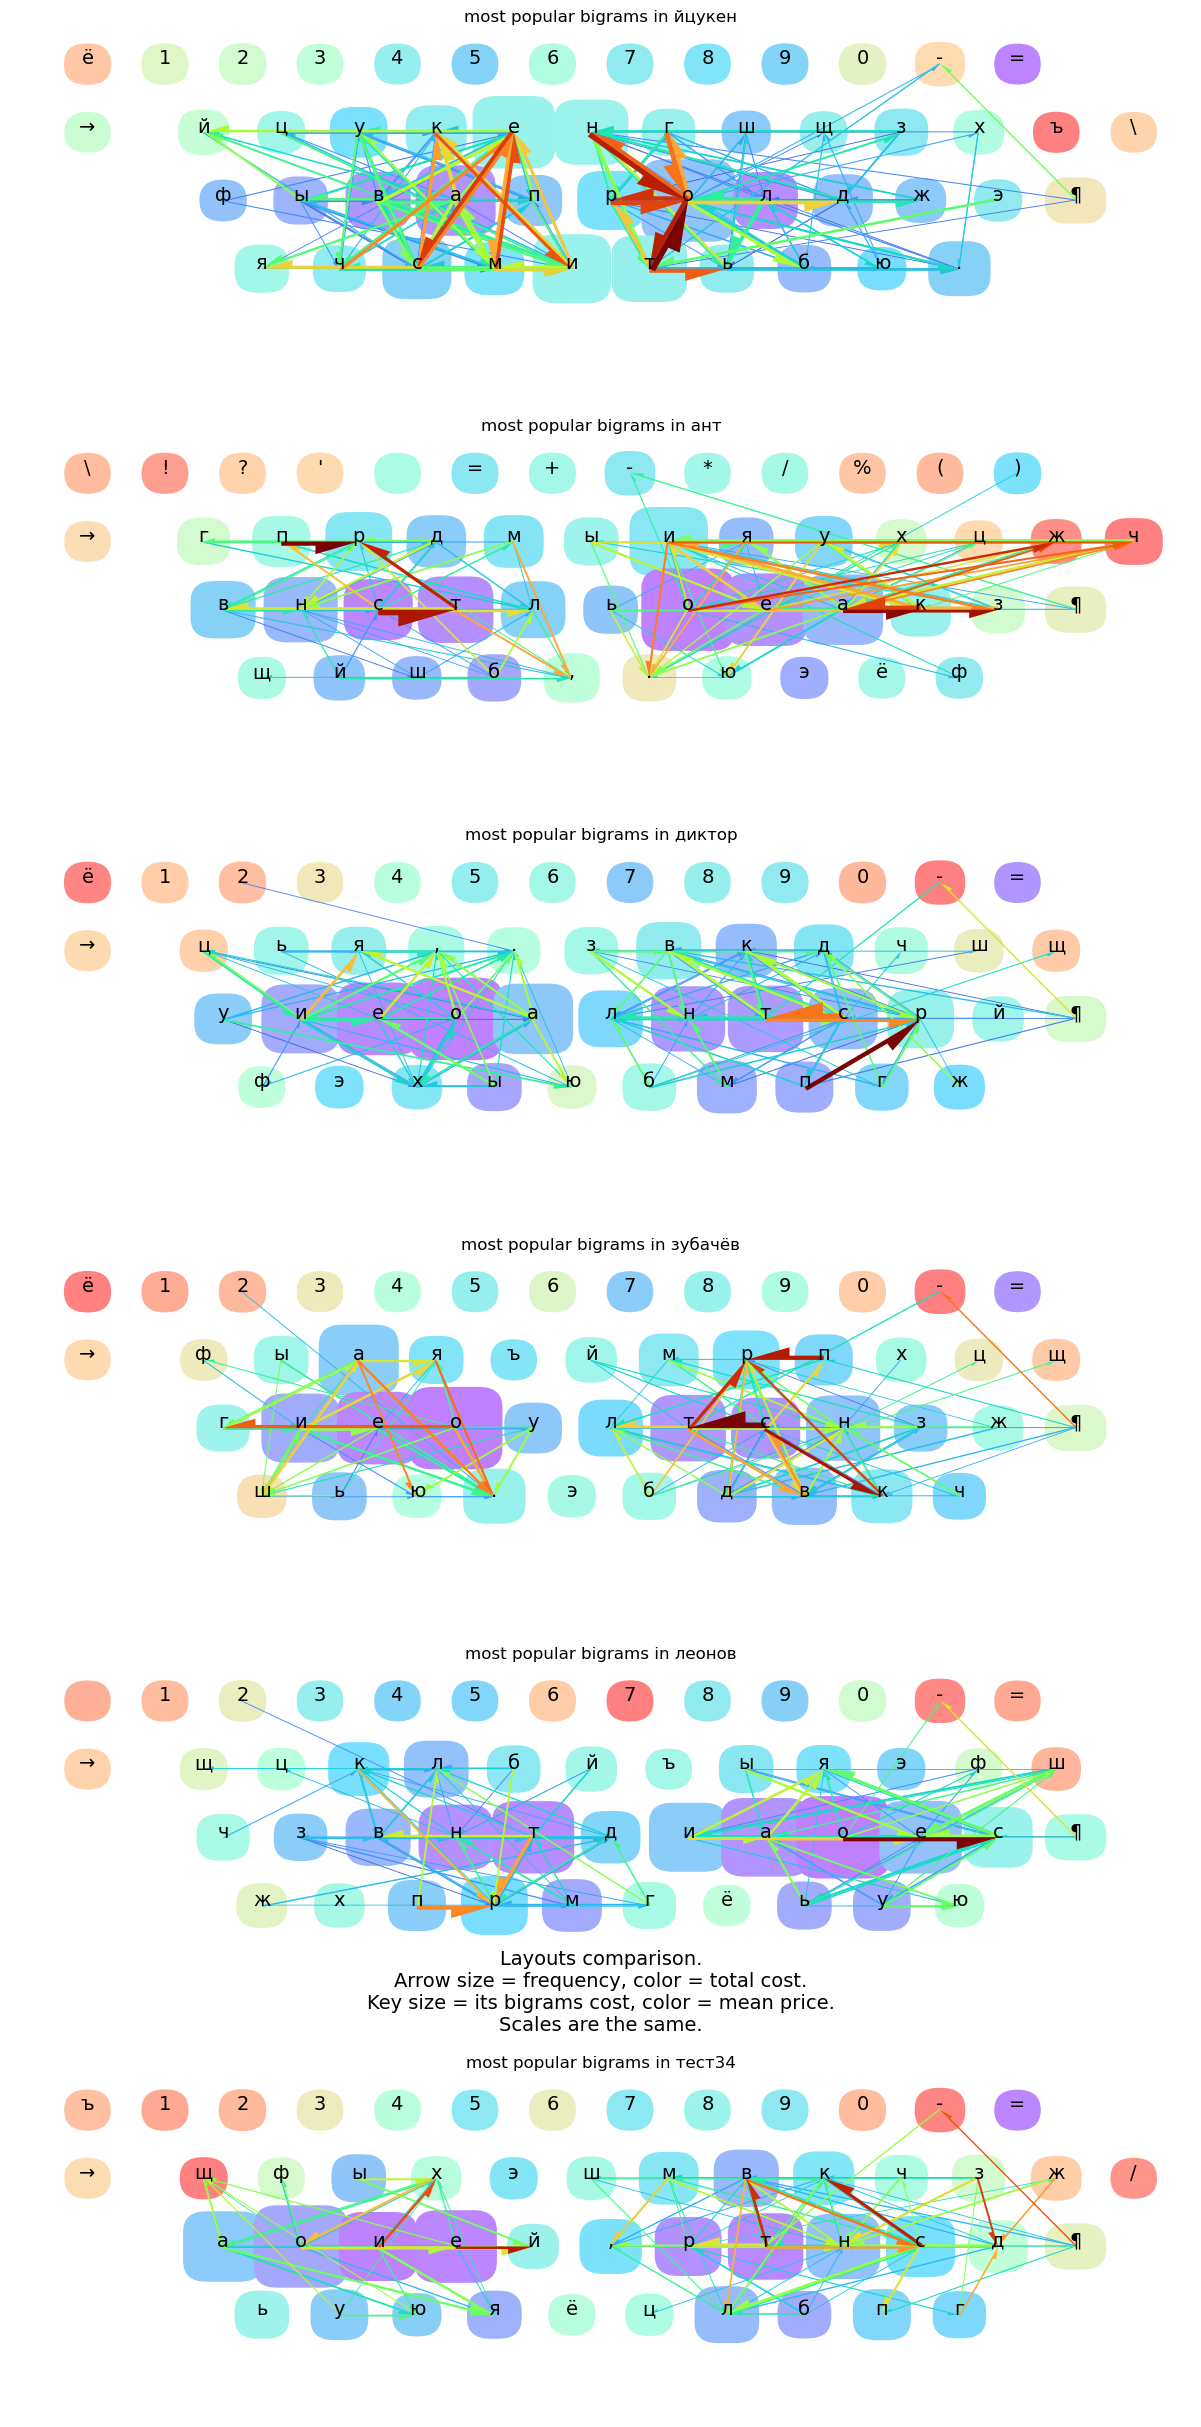

In [28]:
rs = results
rs['йцукен'].combomap(rs['ант'], rs['диктор'], rs['зубачёв'], rs['леонов'], rs['тест34'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

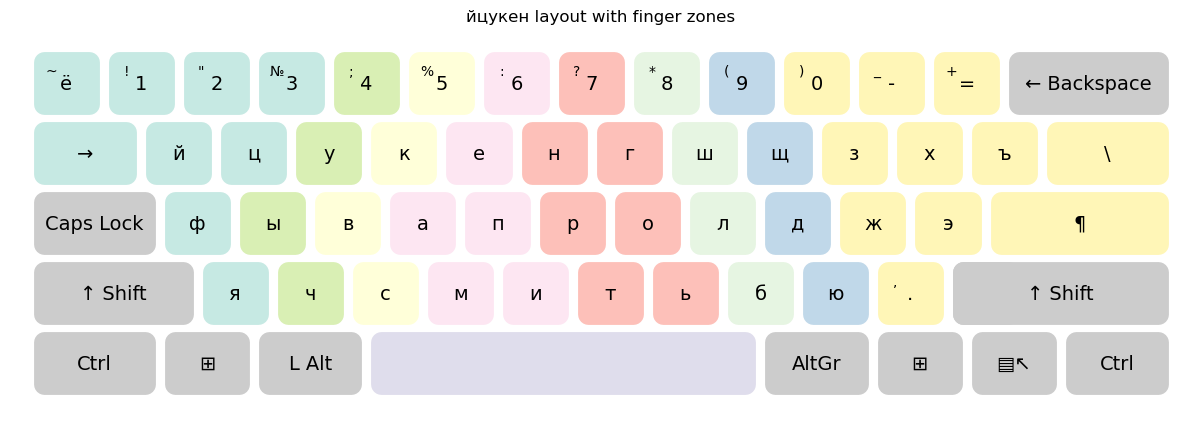

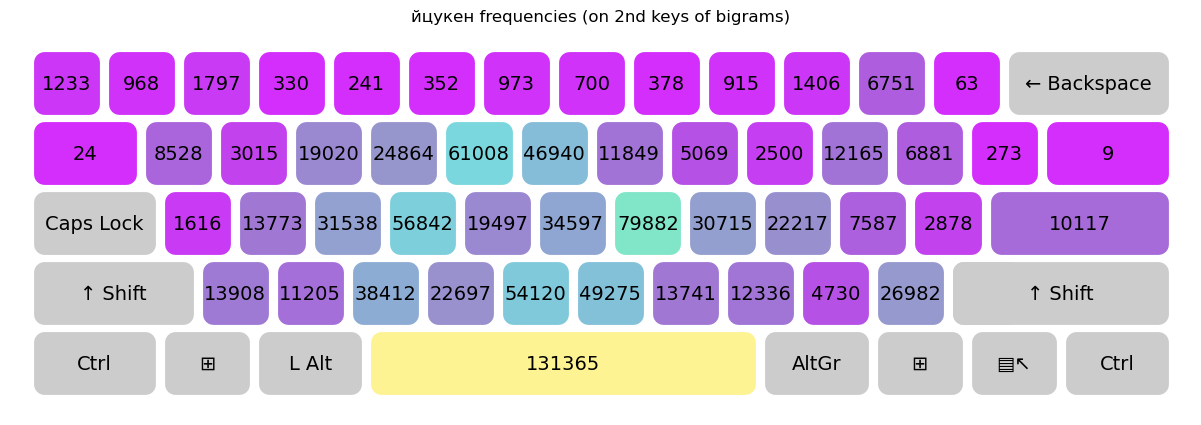

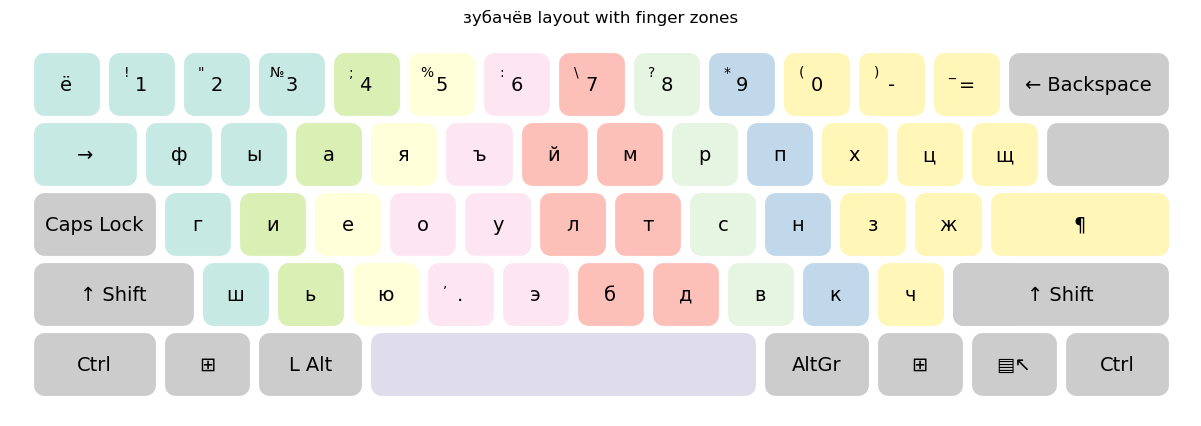

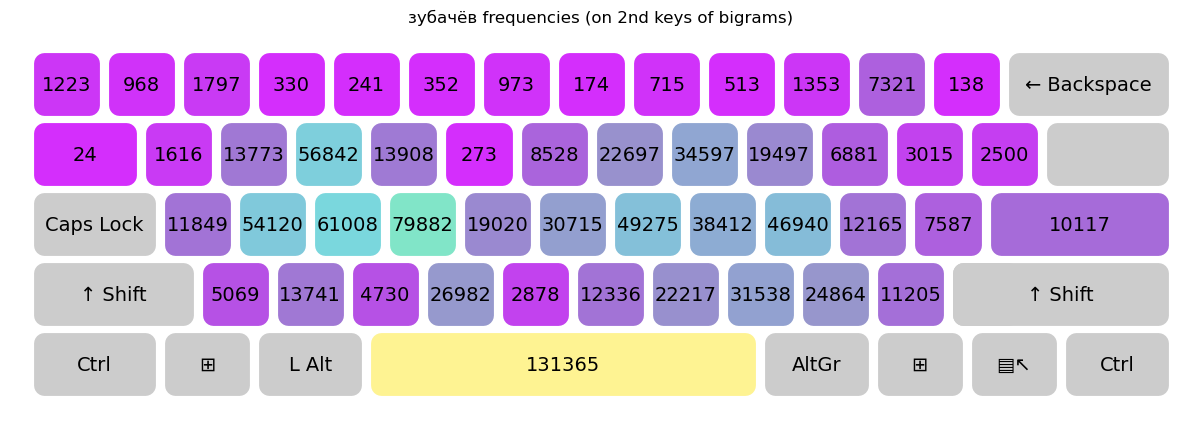

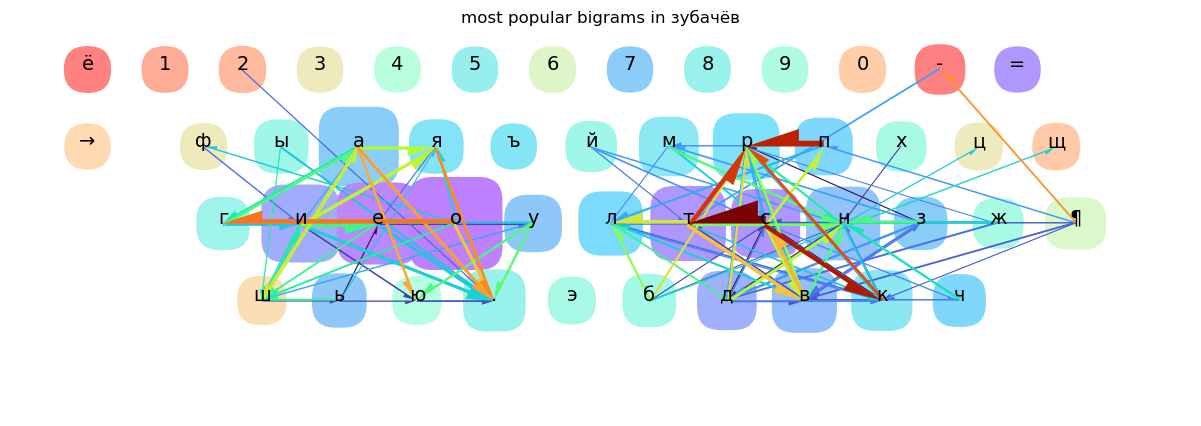

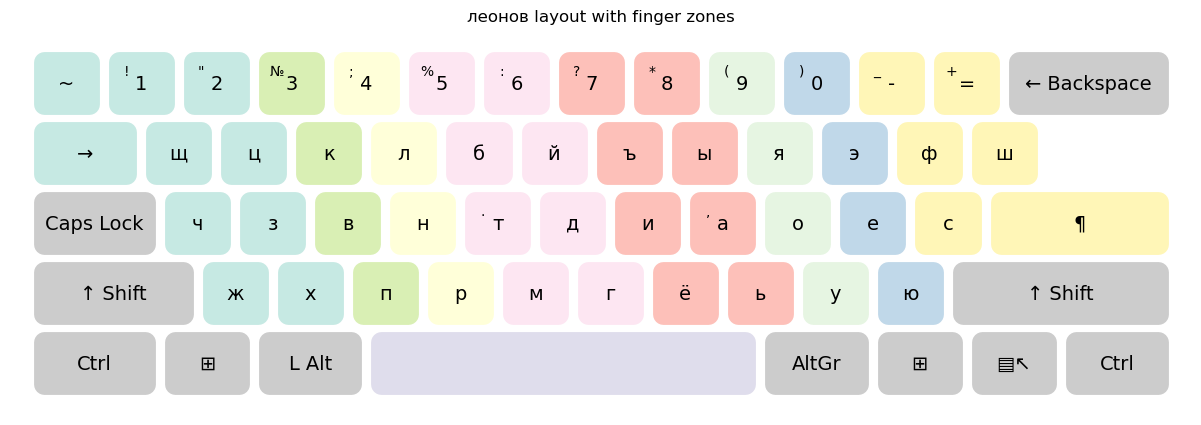

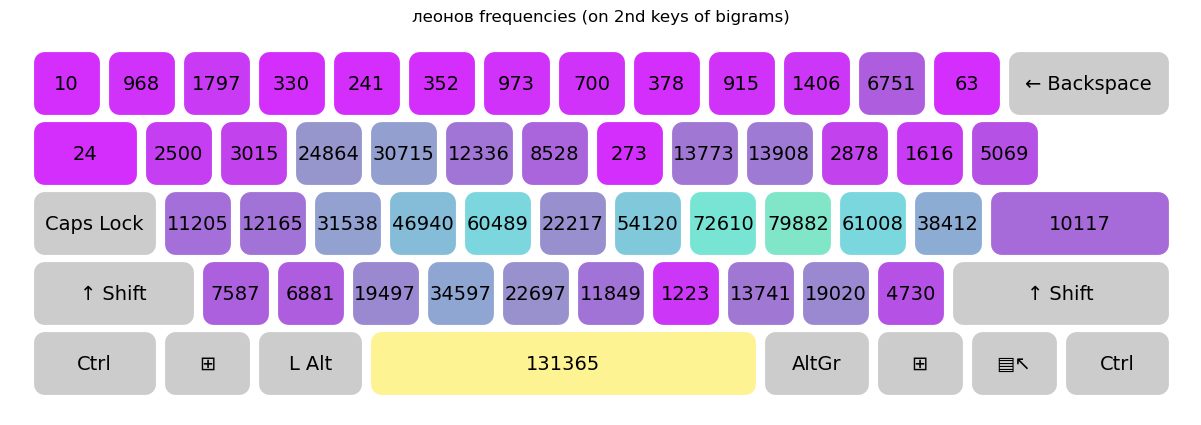

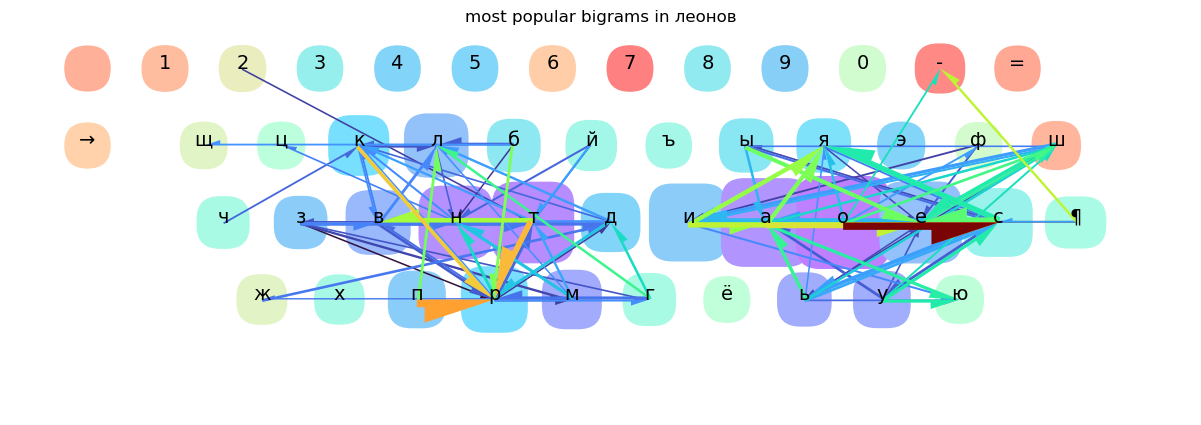

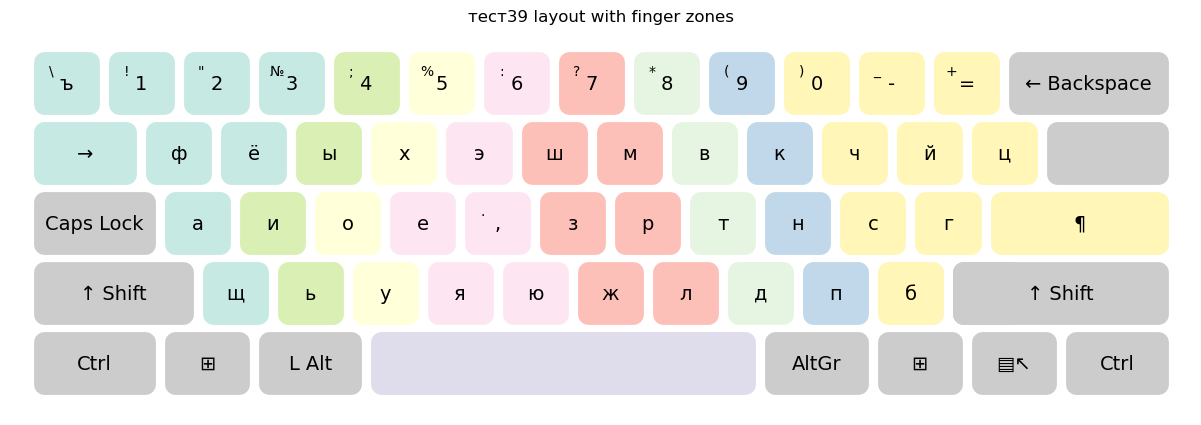

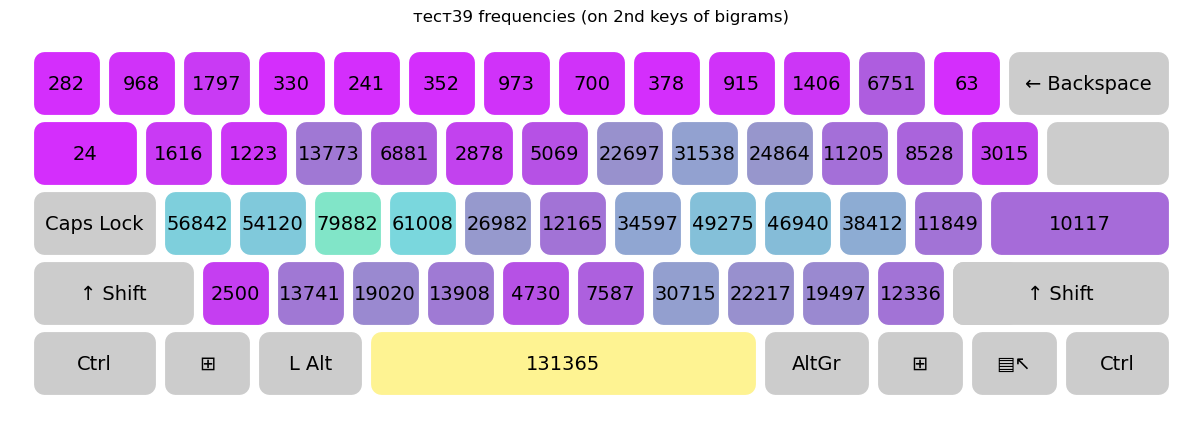

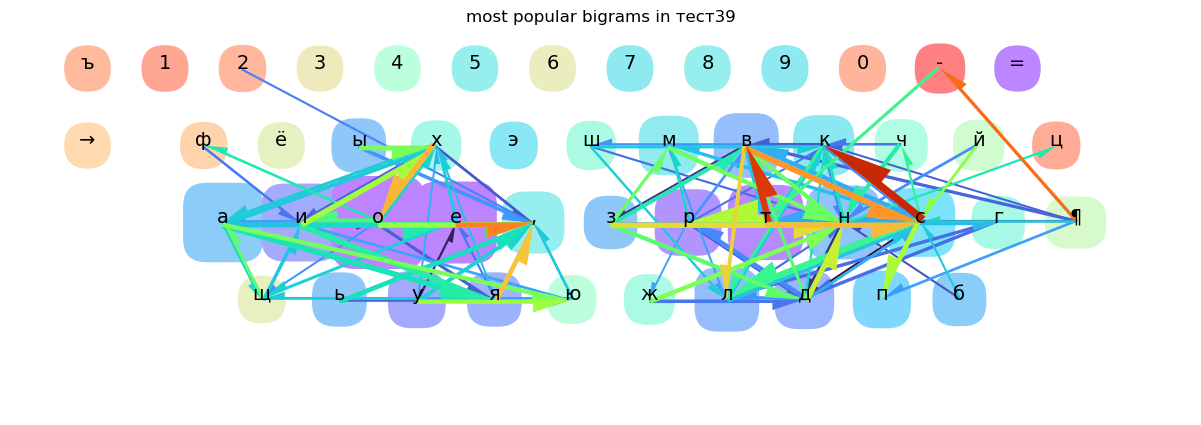

In [29]:
results['йцукен'].display('layout', 'num')
results['зубачёв'].display('layout', 'num', 'arrows')
results['леонов'].display('layout', 'num', 'arrows')
results['тест39'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [30]:
cmp = compare(results, 'леонов', 'тест39')
cmp.head(30)

bigram    num                     category_old  price_old  cost_old  \
105     на   8003                     altern hands          0         0   
10      ра   7597                     altern hands          0         0   
66      ⌴н  11829                        space bar          0         0   
272     е,   1459      in, over 1 finger, same row          0         0   
115     ка   5674                     altern hands          0         0   
25      ⌴м   5232                        space bar          1      5232   
92      та   4987                     altern hands          0         0   
194     хо   1638                     altern hands          0         0   
36      ва   4893                     altern hands          0         0   
53      ¶¶   4802                         same key          4     19208   
114     ск   3125                     altern hands          2      6250   
173     да   4133                     altern hands          0         0   
191     ом   4114                     altern hands          1      4114   
196     зн   1644      in, over 1 finger, same row          0         0   
132     я,   1162                    in, lower row          1      1162   
177     .¶   3921                     altern hands          4     15684   
465     вс   1832                     altern hands          2      3664   
365     е.    905                     altern hands          0         0   
21      за   3576                     altern hands          0         0   
253     ла   3559                     altern hands          0         0   
102     ем   3307                     altern hands          1      3307   
185     ен   6600                     altern hands          0         0   
130     тс   1614                     altern hands          2      3228   
350     я.    806                     altern hands          0         0   
181     ой   3205                     altern hands          4     12820   
338     вл    794  in, adj finger, same or adj row          3      2382   
411     дн   1467           index->middle same row          1      1467   
38      ть   5581                     altern hands          1      5581   
106     им   2603                     altern hands          1      2603   
916     ща    415                     altern hands          0         0   

                category_new  price_new  cost_new  delta  
105             altern hands          2     16006  16006  
10              altern hands          2     15194  15194  
66                 space bar          1     11829  11829  
272      same finger adj row          8     11672  11672  
115             altern hands          2     11348  11348  
25                 space bar          3     15696  10464  
92              altern hands          2      9974   9974  
194      same finger adj row          6      9828   9828  
36              altern hands          2      9786   9786  
53                  same key          6     28812   9604  
114  pinky -> ring, next row          5     15625   9375  
173             altern hands          2      8266   8266  
191             altern hands          3     12342   8228  
196     out, over one finger          5      8220   8220  
132      same finger adj row          8      9296   8134  
177             altern hands          6     23526   7842  
465     out, over one finger          6     10992   7328  
365      same finger adj row          8      7240   7240  
21              altern hands          2      7152   7152  
253             altern hands          2      7118   7118  
102             altern hands          3      9921   6614  
185             altern hands          1      6600   6600  
130     out, over one finger          6      9684   6456  
350      same finger adj row          8      6448   6448  
181             altern hands          6     19230   6410  
338      adj finger over row         11      8734   6352  
411     out, over one finger          5      7335   5868  
38              altern han

In [31]:
cmp.tail(30)

bigram   num                     category_old  price_old  cost_old  \
211     ер  4779                     altern hands          1      4779   
180     ре  4808                     altern hands          1      4808   
195     од  4816                     altern hands          2      9632   
225     ⌴б  4888                        space bar          3     14664   
156     ис  2458                   index -> pinky          4      9832   
190     а,  1328              same finger adj row          6      7968   
277     ая  1782             out, over one finger          5      8910   
7       ли  5507                     altern hands          2     11014   
184     ое  1887             out, over one finger          5      9435   
227     ⌴д  5792                        space bar          2     11584   
491     гл   645              adj finger over row         11      7095   
262     ия  1949             out, over one finger          5      9745   
69      ор  5921                     altern hands          1      5921   
218     ше  1528          pinky -> ring, next row          4      6112   
300     и,  1600              same finger adj row          6      9600   
238     ас  3302                   index -> pinky          4     13208   
256     ые  1696             out, over one finger          5      8480   
15      ни  7156                     altern hands          2     14312   
67      не  7581                     altern hands          1      7581   
252     пл   786              adj finger over row         11      8646   
129     ае  1585             out, over one finger          5      7925   
404     се  2649  in, adj finger, same or adj row          3      7947   
324     бр   812              adj finger over row         11      8932   
23      ⌴и  9284                        space bar          2     18568   
78      тр  3288             out, over one finger          5     16440   
155     ие  2374             out, over one finger          5     11870   
41      пр  6010  in, adj finger, same or adj row          3     18030   
31      кр  1386              adj finger over row         11     15246   
61      ес  4129             out, over one finger          6     24774   
56      ос  5489             out, over one finger          6     32934   

                        category_new  price_new  cost_new  delta  
211                     altern hands          0         0  -4779  
180                     altern hands          0         0  -4808  
195                     altern hands          1      4816  -4816  
225                        space bar          2      9776  -4888  
156                     altern hands          2      4916  -4916  
190      in, over 1 finger, same row          2      2656  -5312  
277       in, over 1 finger, adj row          2      3564  -5346  
7                       altern hands          1      5507  -5507  
184  in, adj finger, same or adj row          2      3774  -5661  
227                        space bar          1      5792  -5792  
491       in, over 1 finger, adj row          2      1290  -5805  
262       in, over 1 finger, adj row          2      3898  -5847  
69                      altern hands          0         0  -5921  
218                     altern hands          0         0  -6112  
300      in, over 1 finger, same row          2      3200  -6400  
238                     altern hands          2      6604  -6604  
256       in, over 1 finger, adj row          1      1696  -6784  
15                      altern hands          1      7156  -7156  
67                      altern hands          0         0  -7581  
252      in, over 1 finger, same row          1       786  -7860  
129      in, over 1 finger, same row          0         0  -7925  
404                     altern hands          0         0  -7947  
324       in, over 1 finger, adj row          1       812  -8120  
23                         space bar          1      9284  -9284  
78   in, adj finger, same or adj r